# Data Science Methods for Clean Energy Research 
## _Multiple linear regression_

## Outline

Today we will move beyond the simple one independent variable **linear regression** and look at how to choose, train and predict using **multiple linear regression**. 

### 1. Introduction to multiple linear regression
#### 1.1 Multiple linear regression
#### 1.2 Let's run this in Python for a new dataset - the diabetes dataset 
#### 1.3 Accuracy of multiple linear regression fit
#### 1.4 Feature selection

* 1.4.1 _F-statistic_ to estimate relationship between response and predictors
* 1.4.2 Forward and Backward stepwise selection


#### 1.5 Potential issues with linear regression



---







### Load libraries which will be needed in this Notebook



In [13]:
# Pandas library for the pandas dataframes
import pandas as pd    

# Import Scikit-Learn library for the regression models
import sklearn         
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# Note - you will need version 0.24.1 of scikit-learn to load this library (SequentialFeatureSelector)
from sklearn.feature_selection import f_regression, SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Import numpy 
import numpy as np

# Another statistic model library
import statsmodels.api as sm
import statsmodels.formula.api as smf

import scipy.stats as stats
import scipy
from scipy import interpolate
from scipy.interpolate import interp1d

# Import plotting libraries
import seaborn as sns
import matplotlib 
from matplotlib import pyplot as plt
# Set larger fontsize for all plots
matplotlib.rcParams.update({'font.size': 20})

# Command to automatically reload modules before executing cells
# not needed here but might be if you are writing your own library 
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
print(sklearn.__version__)

1.0.2


## 1. What is mutiple linear regression? 

Recall from last time. We were fitting the position of the Cheetah as a function of time only. However, the **speed** or velocity of the Cheetah (the dependent variable v) could depend on:

* his/her **energy** (independent variable E) that day
* how well the Cheetah **slept** the night before (independent variable sleep, S) 
* whether she/he was well **fed** (independent variable, F) 
* how much he or she has been **training** recently (independent variable, T)

Each of these could be considered as an input feature _X_ ... and perhaps the position depends on many or all of these features ... How do we take this into account?

### 1.1 Multiple linear regression 

It is the process of predicting a **_dependent_** variable _Y_ based on <span style="color:blue"> **more than one** </span> **_independent_** variable $X_1$, $X_2$, ..., $X_p$ with $p$ the number of parameters using a multiple linear regression model:

$$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_p X_p + \epsilon\;\;\;\;\;\sf{eq. 1}$$ 


The $\left\{\beta_i\right\}_{i=0}^{p}$ **_coefficients_** / **_parameters_** are estimated using least squares, as we did for simple linear regression


Specifically we need to minimize the **residual sum of squares** (RSS) which for  $N$ points $\left\{(x_{0,1},x_{0,2},...,x_{0,p},y_0),...,(x_{N,1},x_{N,2},...,x_{N,p},y_0)\right\}$ can be written as

$${\sf RSS} =\sum_{i=1}^{N}\left(y_i - \hat{y}_i\right)^2 = \sum_{i=1}^{N}\left(y_i - \hat{\beta}_0 -\hat{\beta}_1 x_{i,1} -\hat{\beta}_2 x_{i,2} \;-\;...\;-\;\hat{\beta}_p x_{i,p}\right)^2\;\;\;\;\sf{eq. 2}$$

The optimal values -i.e. the parameter estimators $\left\{\hat{\beta}_i\right\}_{i=0}^{p}$  can be represented using matrix algebra. If you are interested you can find them on [wikipedia](https://en.wikipedia.org/wiki/Linear_regression#Simple_and_multiple_linear_regression).

### 1.2 Let's run this in Python for a new dataset - the diabetes dataset 

For more information on this dataset see [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset).

In [15]:
dset = datasets.load_diabetes()

X, y = dset.data, dset.target
print(dset.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

### In class exercise

Use the values of X and y and the `scikit-learn` [`linear_model.LinearRegression()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) class to fit a multilinear regression model. Use the first 3 input features.

* Define a train and test set
* Fit the model on the ... set
* Predict the values of y for the ... set
* Plot predicted respect to fitted 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=9, shuffle=True)

In [17]:
Nfeat = 3
regr = linear_model.LinearRegression()
regr.fit(X_train[:,0:Nfeat], y_train)

LinearRegression()

In [18]:
betas = regr.coef_
beta0 = regr.intercept_

print("intercept", beta0)
print("coefficients", betas)

intercept 152.47634442066885
coefficients [144.8851704  -34.13104195 864.92226252]


In [19]:
y_predict = regr.predict(X_test[:,0:Nfeat])

print(X_test[:,0:Nfeat].shape, y_predict.shape)

(93, 3) (93,)


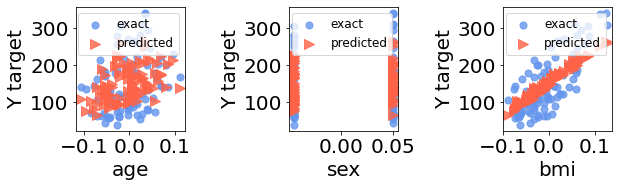

In [20]:
# Lets plot exact positions respect to the time values using a scatter plot
fig, ax = plt.subplots(1,Nfeat,figsize=(Nfeat*3,3))
for i in range(Nfeat):
  
    ax[i].scatter(X_test[:,i], y_test, s=50, marker='o', color="cornflowerblue", alpha=0.8, label="exact")
    ax[i].scatter(X_test[:,i], y_predict, s=100, marker='>', color="tomato", alpha=0.8, label="predicted")
    ax[i].set_xlabel(dset.feature_names[i])
    ax[i].set_ylabel('Y target')
    ax[i].legend(fontsize=12)

plt.tight_layout()

### 1.3 Accuracy of multiple linear regression fit

We can look at the residual standard error, RSE which for multiple linear regression has the expression:

$$\sigma \equiv \text{RSE}= \sqrt{\frac{\text{RSS}}{N-p -1}}\;\;\;\;\;\sf{eq. 6}$$

with RSS the residual sum of squares, i.e.

$$\text{RSS} = \sum_{i=1}^{N} \left(y_i - \hat{y}_i\right)^2\;\;\;\;\;\sf{eq. 7}$$

we can normalize the RSS by the number of points N to retrieve the MSE as a metric of error of our fit 

In [21]:
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_predict))

Mean squared error: 2519.69


We can also look at the regression score $R^2$ as we did for simple linear regression


$$R^2 = 1 - \frac{\text{RSS}}{\text{TSS}}\;\;\;\;\sf{eq. 8}$$

with 

$$\text{TSS}=\sum_{i=1}^N \left(y_i-\bar{y}\right)^2\;\;\;\;\sf{eq. 9}$$

The best value of $R^2$ is 1 but it can also take a negative value if the error is large.

In [22]:
print('Coefficient of determination: %.2f' % r2_score(y_test, y_predict))

Coefficient of determination: 0.56


Our error and coefficient of determination indicate that we are not doing a great job in predicting .. 

* Do we need more input features? 
* How are our independent variables correlated to our target?
* Which input features should we choose?

### 1.4 Feature selection

### 1.4.1 _F-statistic_ to estimate relationship between response and predictors

If this was simple linear regression our alternative hypothesis would be - the target value depends on the slope $\beta_1$ and the null hypothesis would be - the target values does not depend on the slope.

Let's extend this to multilinear regression

We hypothesize
* Null hypothesis $H_0:\;\beta_1=\beta_2=...=\beta_p=0$ there is no dependence on any input feature
* Alternative hypothesis $H_a:$ at least one $\beta_j\neq0$ it depends at least on one input feature

We can verify this hypothesis using the so-called $F-statistic$ (more info [here](https://en.wikipedia.org/wiki/F-test) and also [here](https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/feature_selection/_univariate_selection.py#L232))

$$F=\frac{(\text{TSS}-\text{RSS})/p}{\text{RSS}/(N-p-1)}\;\;\;\;\sf{eq. 3}$$
$$\text{RSS} = \sum_{i=1}^{N} \left(y_i - \hat{y}(x_i)\right)^2\;\;\;\;\;\sf{eq. 4}$$

$$\text{TSS}=\sum_{i=1}^N \left(y_i-\bar{y}\right)^2\;\;\;\;\sf{eq. 5}$$


If the linear model assumptions are correct - i.e. the alternative hypothesis is correct then one would expect $F$ to be greater than 1. 

One can also iteratively test each input feature or sets of input features, the expression is slightly different respect to the equation above. Let's do this in python using the `scipy` `OLS()` [function](https://www.statsmodels.org/stable/_modules/statsmodels/stats/contrast.html#ContrastResults.summary).

In [23]:
mreg = sm.OLS(y_train, X_train).fit()
mreg.summary(alpha=0.1) # Set significance level

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.108
Model:                            OLS   Adj. R-squared (uncentered):              0.081
Method:                 Least Squares   F-statistic:                              4.084
Date:                Thu, 17 Feb 2022   Prob (F-statistic):                    2.52e-05
Time:                        09:09:33   Log-Likelihood:                         -2271.2
No. Observations:                 349   AIC:                                      4562.
Df Residuals:                     339   BIC:                                      4601.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|       [0.05       0.95]
------------------------------------------------------------------------------
x1            29.2588    201.959      0.145      0.885    -303.845     362.362
x2          -256.4392    210.437     -1.219      0.224    -603.526      90.647
x3           499.2333    223.557      2.233      0.026     130.506     867.960
x4           374.6832    226.155      1.657      0.098       1.672     747.695
x5          -835.9922   1399.755     -0.597      0.551   -3144.693    1472.708
x6           690.8964   1152.825      0.599      0.549   -1210.528    2592.321
x7           -79.6397    714.438     -0.111      0.911   -1258.006    1098.726
x8          -115.3036    552.923     -0.209      0.835   -1027.274     796.666
x9           803.5930    576.979      1.393      0.165    -148.054    1755.240
x10           78.5195    226.238      0.347      0.729    -294.629     451.668
==============================================================================
Omnibus:                        1.814   Durbin-Watson:                   0.216
Prob(Omnibus):                  0.404   Jarque-Bera (JB):                1.623
Skew:                          -0.048   Prob(JB):                        0.444
Kurtosis:                       2.680   Cond. No.                         20.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that the F value is larger than one and the p-value less than $\alpha$ therefore we can reject the null hypothesis. This means that there is some correlation between our input features and target output. 

### 1.4.2 Forward and Backward stepwise selection

Which are the best input features - independent variables? Should we test every possible combination?

One class of methods to find the best input features is **Subset Selection**. Here the approaches aim to indentify a subset of $p$ predictions which are related to the response $y$ and fitting a model using least squares.

Two other important classes of methods include **Shrinkage** and **Dimension Reduction**. For more information see Chapter 6 section 6.1 of the textbook.

We will look at two **Stepwise Selection** methods from the first class:

* Forward Stepwise Selection
* Backward Stepwise Selection

Let's see how to do this in scikit-learn [`SequentialFeatureSelector()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html)

### Forward stepwise selection

Foward stepwise selection starts with a model with **no** predictors, $\beta$ and then at each step it adds the input variable which leasds to the largest improvement to the fit

**_step 1_** Start with $\mathcal{M}_0$ the _null_ model with no predictors

**_step 2_** For $k=0,...,p-1$:
  * Consider all models with $p-k$ parameters which increase the number of predictors in $\mathcal{M}_k$ by one
  * Choose the best of the above set of models (with the smallest RSS or highest $R^2$ score - we will call it $\mathcal{M}_{k+1}$

**_step 3_** Select the best among these models {$\mathcal{M}_0$,...,$\mathcal{M}_p$} using cross-validated prediction error (we will see cross-validation in the next lecture)

Note: You can use forward feature selection even when $N<p$ but you will only be able to evaluate submodels up to $p=N-1$, for larger values of $p$ the solution is not unique.

In [24]:
# Find features which are most important
sfs_forward = SequentialFeatureSelector(linear_model.LinearRegression(), 
                                        n_features_to_select=3,
                                        direction='forward').fit(X, y)

# Print features which are most important
f_names = np.array(dset.feature_names)
print(sfs_forward.get_support(),"\n")
selected = sfs_forward.get_support(indices=True)
print("Selected input features using Forward Stepwise Selection:\n", f_names[selected])


[False False  True  True False False False False  True False] 

Selected input features using Forward Stepwise Selection:
 ['bmi' 'bp' 's5']


### Backward stepwise selection

Backward stepwise selection starts with a model with **all** predictors, $\beta$ and then at each step it adds the input variable which leasds to the largest improvement to the fit

**_step 1_** Start with $\mathcal{M}_p$ the _full_ model with all predictors

**_step 2_** For $k=p,p-1,...,1$:
  * Consider all models with $k$ parameters which decrease the number of predictors in $\mathcal{M}_k$ by one
  * Choose the best of the above set of models (with the smallest RSS or highest $R^2$ score - we will call it $\mathcal{M}_{k-1}$

**_step 3_** Select the best among these models {$\mathcal{M}_0$,...,$\mathcal{M}_p$} using cross-validated prediction error (we will see cross-validation in the next lecture)

Note: Here $N>=p$ must be satisfied - otherwise the full model can't be fit. 

In [25]:
sfs_backward = SequentialFeatureSelector(linear_model.LinearRegression(), 
                                        n_features_to_select=3,
                                        direction='backward').fit(X, y)

f_names = np.array(dset.feature_names)
print(sfs_backward.get_support(),"\n")
selected = sfs_backward.get_support(indices=True)
print("Selected input features using Backward Stepwise Selection:\n", f_names[selected])

[False False  True  True False False False False  True False] 

Selected input features using Backward Stepwise Selection:
 ['bmi' 'bp' 's5']


### 1.5 Potential issues with linear regression

When fitting data using a linear regression model some issues can occur. Amongst these we will look at the case when the **response-predictor relationship is non-linear**. This can be identified if a pattern is in the residual plot for linear fit


In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(y_test, y_test-y_predict, marker='o')
ax[0].set_title('Residual plot for linear fit\n', fontsize=15)
ax[0].set_xlabel('y_test')
degree = 5
model = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
model.fit(X, y)
y_poly = model.predict(X_test)

ax[1].scatter(y_test, y_test-y_poly, c="purple")
ax[1].set_title('Residual plot for polynomial fit\n', fontsize=15)
ax[1].set_xlabel('y_test')
plt.tight_layout()

We see a pattern in the residuals for the linear fit which looks non linear. This should not be the case. 

There are other possible problems to keep in mind - let's go back to the slides to see these.
